# Coursework2: Convolutional Neural Networks 

## instructions

Please submit a version of this notebook containing your answers **together with your trained model** on CATe as CW2.zip. Write your answers in the cells below each question.

A PDF version of this notebook is also provided in case the figures do not render correctly.

**The deadline for submission is 19:00, Thu 14th February, 2019**

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so. 

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [0]:
!pip install torch torchvision

## Introduction

For this coursework you will implement one of the most commonly used model for image recognition tasks, the Residual Network. The architecture is introduced in 2015 by Kaiming He, et al. in the paper ["Deep residual learning for image recognition"](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf). 
<br>

In a residual network, each block contains some convolutional layers, plus "skip" connections, which allow the activations to by pass a layer, and then be summed up with the activations of the skipped layer. The image below illustrates a building block in residual networks.

![resnet-block](utils/resnet-block.png)

Depending on the number of building blocks, resnets can have different architectures, for example ResNet-50, ResNet-101 and etc. Here you are required to build ResNet-18 to perform classification on the CIFAR-10 dataset, therefore your network will have the following architecture:

![resnet](utils/resnet.png)

## Part 1 (40 points)

In this part, you will use basic pytorch operations to define the 2D convolution and max pooling operation. 

### YOUR TASK

- implement the forward pass for Conv2D and MaxPool2D
- You can only fill in the parts which are specified as "YOUR CODE HERE"
- You are **NOT** allowed to use the torch.nn module and the conv2d/maxpooling functions in torch.nn.functional

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class Conv2D(nn.Module):
    
    def __init__(self, inchannel, outchannel, kernel_size, stride, padding, bias = True):
        
        super(Conv2D, self).__init__()
        
        self.inchannel = inchannel
        self.outchannel = outchannel
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        self.weights = nn.Parameter(torch.Tensor(outchannel, inchannel, 
                                                 kernel_size, kernel_size))
        self.weights.data.normal_(-0.1, 0.1)
        
        if bias:
            self.bias = nn.Parameter(torch.Tensor(outchannel, ))
            self.bias.data.normal_(-0.1, 0.1)
        else:
            self.bias = None
            
        
    def forward(self, x):
        
        ##############################################################
        #                       YOUR CODE HERE                       #       
        ##############################################################
        
        batch_size, _, input_width, input_length = x.shape
        
        '''
        batch_size = batch_size.to(device=torch.device('cuda'))
        input_width = input_width.to(device=torch.device('cuda'))
        input_length = input_length.to(device=torch.device('cuda'))         
        '''


        output_width = ((input_width+2*self.padding-self.kernel_size)//self.stride+1)# .to(device=torch.device('cuda'))
        output_length = ((input_length+2*self.padding-self.kernel_size)//self.stride+1)# .to(device=torch.device('cuda'))
        
        slide = (F.unfold(x, kernel_size=self.kernel_size, padding = self.padding, stride = self.stride)).to(device=torch.device('cuda'))
        if self.bias:
          output_unf = (slide.transpose(1,2).matmul(self.weights.view(self.weights.size(0),-1).t()).transpose(1,2)+self.bias.view(-1,1)).to(device=torch.device('cuda'))
        else:
          output_unf = ((slide.transpose(1,2).matmul(self.weights.view(self.weights.size(0),-1).t()).transpose(1,2))).to(device=torch.device('cuda'))
        
        
        output = (output_unf.view(batch_size, self.outchannel, output_width, output_length)).to(device=torch.device('cuda'))        

        ##############################################################
        #                       END OF YOUR CODE                     #
        ##############################################################
        

        return output
        

In [0]:
class MaxPool2D(nn.Module):
    
    def __init__(self, pooling_size):
        # assume pooling_size = kernel_size = stride
        
        super(MaxPool2D, self).__init__()
        
        self.pooling_size = pooling_size
        

    def forward(self, x):
        
        
        ##############################################################
        #                       YOUR CODE HERE                       #       
        ##############################################################
        '''
        batch_size, channel_size, input_width, input_length = x.shape

        batch_size = batch_size.to(device=torch.device('cuda'))
        channel_size = channel_size.to(device=torch.device('cuda'))
        input_width = input_width.to(device=torch.device('cuda'))
        input_length = input_length.to(device=torch.device('cuda'))           

        output_width = (input_width//self.pooling_size)# .to(device=torch.device('cuda'))
        output_length = (input_length//self.pooling_size)# .to(device=torch.device('cuda'))
        
        output = (torch.Tensor(batch_size, channel_size, output_width, output_length)).to(device=torch.device('cuda'))
        
        for b in range(batch_size):
          for c in range(channel_size):
            for w in range(output_width):
              for l in range(output_length):
                output[b][c][w][l] = (torch.max(x[b][c][(w*self.pooling_size):((w+1)*self.pooling_size),(l*self.pooling_size):((l+1)*self.pooling_size)]).item())
                output = output.to(device=torch.device('cuda'))      
        '''

        x_unf = x.unfold(2,self.pooling_size, self.pooling_size).unfold(3,self.pooling_size, self.pooling_size)
        output = x_unf.contiguous().view(x_unf.size()[:4]+(-1,)).max(dim=-1)[0]
        ##############################################################
        #                       END OF YOUR CODE                     #
        ##############################################################
                
        
        return output
        

In [0]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(Conv2D(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  Conv2D(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2D(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


In [0]:
# define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 10):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2D(3, 64, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(64), 
                                  nn.ReLU())
        
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2D(4)
        self.fc = nn.Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x
    
    
def ResNet18():
    return ResNet(ResidualBlock)

## Part 2 (40 points)

In this part, you will train the ResNet-18 defined in the previous part on the CIFAR-10 dataset. Code for loading the dataset, training and evaluation are provided. 

### Your Task

1. Train your network to achieve the best possible test set accuracy after a maximum of 10 epochs of training.

2. You can use techniques such as optimal hyper-parameter searching, data pre-processing

3. If necessary, you can also use another optimiser

4. **Answer the following question:**
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? 


**YOUR ANSWER FOR 2.4 HERE**

A:
*    **Searching model:** Bayesian Optimisation or Gaussian Process Optimisition, at least comparing with the grid search and random search, is a better strategy for hyperparameter searching. Since the strategy will create a proxy model of the true model and train the hyperparameters on a more cheaper proxy model and return a really good result. And Training may be very cheaper compared with other strategies. Besides that,  using Bayesian Optimization can help to speed up the process by reducing the computation task. 
*  **Searching stategy: **As for the search space, we can first make a large search space to estimate the approximate interval of the best parameters, then we can uniformly search a much smaller search space based on our approximation.
*  **Directly using testsets to test the performance**. In such cases, we can't use cross validation, which is too expensive.


In [0]:
!rm -rf ./data

In [0]:
################################################################################
####################    Load data with preprocessing   #########################
################################################################################

import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset

import numpy as np

import torchvision.transforms as T


transform = T.ToTensor()

##################### preprocessing data #########################

transform_train = T.Compose([
    T.RandomCrop(32, padding=4), 
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# load data

NUM_TRAIN = 49000
print_every = 100


data_dir = './data'
cifar10_train = dset.CIFAR10(data_dir, train=True, download=True, transform=transform_train)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10(data_dir, train=True, download=True, transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10(data_dir, train=False, download=True, transform=transform_test)
loader_test = DataLoader(cifar10_test, batch_size=64)


USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
# print(device)


Files already downloaded and verified
Files already downloaded and verified


In [0]:
!pip install hyperopt

In [0]:
def check_accuracy(loader, model):
    # function for test accuracy on validation and test set
    
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc


def train_part(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print(len(loader_train))
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                #check_accuracy(loader_val, model)
                print()

In [0]:
################################################################################
# First try, the search space is large, from 1e-9 to 0.1                       #
# {'eps': 6.199840646550103e-06,                                               #
#  'lr': 0.00046573951327817437,                                               #
#  'weight_decay': 4.3839018654452215e-05}                                     #
################################################################################
import hyperopt
from hyperopt import fmin, tpe, hp,STATUS_OK,Trials

def objective(params):
  model = ResNet18()
  optimizer = optim.Adam(model.parameters(),
                             lr = params['lr'], 
                             weight_decay = params['weight_decay'],
                             # eps=params['eps']
                            )
  train_part(model, optimizer, epochs = 10)
  acc = check_accuracy(loader_test, model)
  loss = 1 - acc
  return {'loss': loss, 'params': params, 'status': STATUS_OK}
#Hyperparameter Setting
space = {
    'lr' : hp.uniform('lr', 1e-9, 0.1),
    # 'weight_decay': hp.uniform('weight_decay',1e-5, 1e-4),
    #'eps': hp.loguniform('eps',np.log(1e-10), np.log(1e-3))
}

# Algorithm
tpe_algorithm = tpe.suggest

# Initialising Trials
# bayes_trials = Trials()
all_trials = Trials()

MAX_EVALS = 10
 
# Optimize  using random search
best = fmin(fn = objective, space = space, algo = tpe_algorithm, 
            max_evals = MAX_EVALS, trials = all_trials)

766
Epoch: 0, Iteration 0, loss = 2.4750

Epoch: 0, Iteration 100, loss = 2.1143

Epoch: 0, Iteration 200, loss = 2.0517

Epoch: 0, Iteration 300, loss = 2.1307

Epoch: 0, Iteration 400, loss = 2.0561

Epoch: 0, Iteration 500, loss = 1.7911

Epoch: 0, Iteration 600, loss = 1.8925

Epoch: 0, Iteration 700, loss = 1.8753

766
Epoch: 1, Iteration 0, loss = 1.9736

Epoch: 1, Iteration 100, loss = 1.8271

Epoch: 1, Iteration 200, loss = 2.0490

Epoch: 1, Iteration 300, loss = 1.8738

Epoch: 1, Iteration 400, loss = 1.8248

Epoch: 1, Iteration 500, loss = 1.8477

Epoch: 1, Iteration 600, loss = 1.9138

Epoch: 1, Iteration 700, loss = 1.8078

766
Epoch: 2, Iteration 0, loss = 1.7940

Epoch: 2, Iteration 100, loss = 2.0558

Epoch: 2, Iteration 200, loss = 2.0737

Epoch: 2, Iteration 300, loss = 1.5785

Epoch: 2, Iteration 400, loss = 1.8577

Epoch: 2, Iteration 500, loss = 1.7955

Epoch: 2, Iteration 600, loss = 1.8765

Epoch: 2, Iteration 700, loss = 1.8868

766
Epoch: 3, Iteration 0, loss = 

In [0]:
print("Best Hyperparameters: ",best)  #Best Hyperparameters:  {'lr': 0.017502974174814428, 'weight_decay': 1.6469676498913387e-05}

Best Hyperparameters:  {'lr': 0.017502974174814428, 'weight_decay': 1.6469676498913387e-05}


In [0]:
################################################################################
# final try, the search space is smaller, from 1e-4 to 0.02(last try got 0.017)#
# and optimising other parameters seems useless in this case, so delete them   #
# Best Hyperparameters:  {'lr': 0.0017263102343447294}                         #
################################################################################

def objective(params):
  model = ResNet18()
  optimizer = optim.Adam(model.parameters(),
                             lr = params['lr'], 
                             weight_decay = params['weight_decay'],                         
                             #weight_decay = 2 * 1e-5,
                             # eps=params['eps']
                            )
  train_part(model, optimizer, epochs = 10)
  acc = check_accuracy(loader_test, model)
  loss = 1 - acc
  return {'loss': loss, 'params': params, 'status': STATUS_OK}
#Hyperparameter Setting
space = {
    'lr' : hp.uniform('lr', 1e-4, 0.02),
    'weight_decay': hp.uniform('weight_decay',1e-5, 1e-4),
    'eps': hp.loguniform('eps',np.log(1e-10), np.log(1e-3))
}

# Algorithm
tpe_algorithm = tpe.suggest

# Initialising Trials
# bayes_trials = Trials()
all_trials = Trials()

MAX_EVALS = 10
 
# Optimize  using random search
best1 = fmin(fn = objective, space = space, algo = tpe_algorithm, 
            max_evals = MAX_EVALS, trials = all_trials)

766
Epoch: 0, Iteration 0, loss = 2.6108

Epoch: 0, Iteration 100, loss = 2.0031

Epoch: 0, Iteration 200, loss = 1.9010

Epoch: 0, Iteration 300, loss = 1.8313

Epoch: 0, Iteration 400, loss = 1.6692

Epoch: 0, Iteration 500, loss = 1.5597

Epoch: 0, Iteration 600, loss = 1.6214

Epoch: 0, Iteration 700, loss = 1.3753

766
Epoch: 1, Iteration 0, loss = 1.2933

Epoch: 1, Iteration 100, loss = 1.4427

Epoch: 1, Iteration 200, loss = 1.3904

Epoch: 1, Iteration 300, loss = 1.2006

Epoch: 1, Iteration 400, loss = 1.0944

Epoch: 1, Iteration 500, loss = 1.2317

Epoch: 1, Iteration 600, loss = 1.2078

Epoch: 1, Iteration 700, loss = 0.8964

766
Epoch: 2, Iteration 0, loss = 0.9176

Epoch: 2, Iteration 100, loss = 1.0048

Epoch: 2, Iteration 200, loss = 1.2929

Epoch: 2, Iteration 300, loss = 0.8887

Epoch: 2, Iteration 400, loss = 0.8945

Epoch: 2, Iteration 500, loss = 0.9691

Epoch: 2, Iteration 600, loss = 0.9665

Epoch: 2, Iteration 700, loss = 0.9777

766
Epoch: 3, Iteration 0, loss = 

In [0]:
model = ResNet18()
print("Best Hyperparameters: ",best)
optimizer = optim.Adam(model.parameters(),
                       lr = best['lr'],
                       # weight_decay = 2 * 1e-5
                      )
train_part(model, optimizer, epochs = 10)
print("Best Accuracy: ",check_accuracy(loader_test, model))
# save the model
torch.save(model.state_dict(), 'model.pt')

Best Hyperparameters:  {'lr': 0.018392441485340492}
766
Epoch: 0, Iteration 0, loss = 2.7153

Epoch: 0, Iteration 100, loss = 2.1589

Epoch: 0, Iteration 200, loss = 1.9713

Epoch: 0, Iteration 300, loss = 1.7815

Epoch: 0, Iteration 400, loss = 1.8164

Epoch: 0, Iteration 500, loss = 1.4354

Epoch: 0, Iteration 600, loss = 1.6906

Epoch: 0, Iteration 700, loss = 1.5830

766
Epoch: 1, Iteration 0, loss = 1.5863

Epoch: 1, Iteration 100, loss = 1.3420

Epoch: 1, Iteration 200, loss = 1.5660

Epoch: 1, Iteration 300, loss = 1.5176

Epoch: 1, Iteration 400, loss = 1.3643

Epoch: 1, Iteration 500, loss = 1.3482

Epoch: 1, Iteration 600, loss = 1.0832

Epoch: 1, Iteration 700, loss = 1.2730

766
Epoch: 2, Iteration 0, loss = 1.3656

Epoch: 2, Iteration 100, loss = 1.1601

Epoch: 2, Iteration 200, loss = 1.1152

Epoch: 2, Iteration 300, loss = 1.4254

Epoch: 2, Iteration 400, loss = 1.2118

Epoch: 2, Iteration 500, loss = 1.1780

Epoch: 2, Iteration 600, loss = 1.2124

Epoch: 2, Iteration 70

In [0]:
## Part 3 (20 points)


The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions**: 

1. Compare the feature maps from low-level layers to high-level layers, what do you observe? 

2. Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance?

3. What are the other possible ways to analyse the performance of your network?

**YOUR ANSWER FOR PART 3 HERE**

A:

**1 Observation of feature maps**

In low-level layers, the number of feature maps is smaller than the high-level layers, and the size of each map in low-level is larger than that in high-level. Besides,  Because of the increasing of the receptive field, the low-level feature maps tends to be simpler like edge detection, etc, while the higher level feature maps are more complex and begin to demonstrate the most useful features.

**2.1 Analyse the performance of my network: **

By using random search to search for the best hyperparameters, I got a relatively low accuracy(around 83%), I think my model is not good enough. 

**2.2 Improvement**

*   Adaptively(mannually) change the learning rate: In the training part, we can first use a large learning rate to get to the minima quickly,  then use a small learning rate when the loss starts to oscillate to find the minima accurately
*   Data preprocessing: I used the tricks like cropping and flipping, but maybe there are also some other tricks, like kai_ming, for date preprocessing or data aumentation.
*   Training epoch:Given that the accuracy rate has become more and more better than previous epochs at each batch, more training epoch may help us get a better result.

**3 Methods of analysing performence**
*  First we can also plot graphs of error rates.
*  And we can use other methods like Confusion Matrix. 
*  If my network is used for other tasks like image segmentation, we can use other tricks like Precision, Recall, Specificity, F1 Score, which are mentioned in lecture, to measure the performance of our model.

<Figure size 576x396 with 0 Axes>

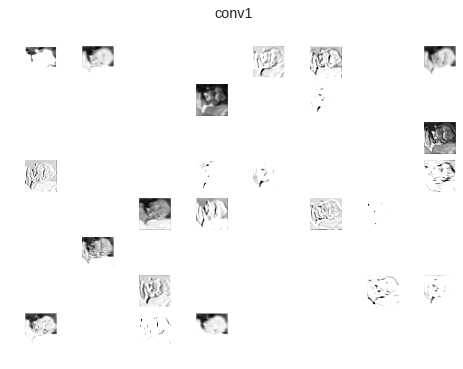

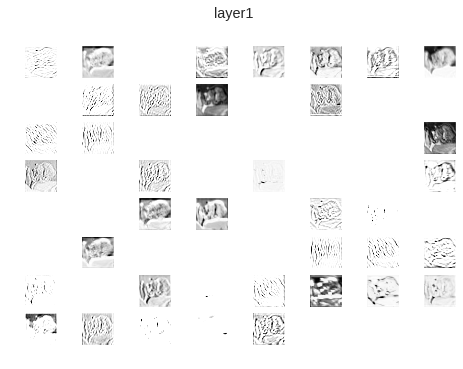

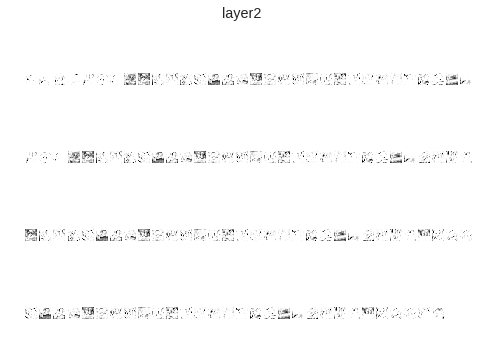

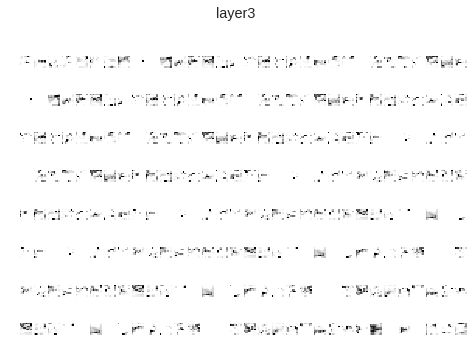

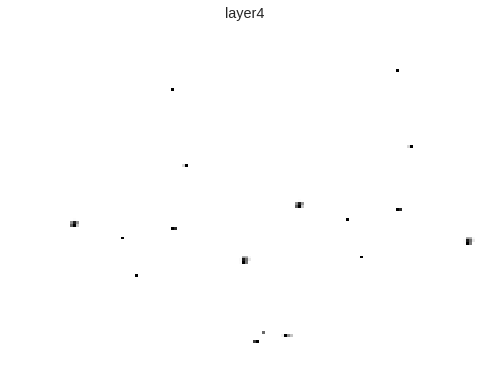

In [0]:
#!pip install matplotlib

import matplotlib.pyplot as plt

plt.tight_layout()


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

for l in vis_labels:

    getattr(model, l).register_forward_hook(get_activation(l))
    
    
data, _ = cifar10_test[0]
data = data.unsqueeze_(0).to(device = device, dtype = dtype)

output = model(data)



for idx, l in enumerate(vis_labels):

    act = activation[l].squeeze()

    if idx < 2:
        ncols = 8
    else:
        ncols = 32
        
    nrows = act.size(0) // ncols
    
    fig, axarr = plt.subplots(nrows, ncols)
    fig.suptitle(l)


    for i in range(nrows):
        for j in range(ncols):
            axarr[i, j].imshow(act[i * nrows + j].cpu())
            axarr[i, j].axis('off')

**=============== END OF CW2 ===============**